In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from S00_utils import plot_res, store_results


In [2]:
df = pd.read_excel("output/S21__2025-04-21-052727.xlsx")
df = df.set_index("Unnamed: 0")
df.index.names = ["id"]
df.head()

,m1,m2,m3,s1__autocorrelation__lag_8,s1__autocorrelation__lag_9,s1__autocorrelation__lag_7,s1__autocorrelation__lag_6,s1__autocorrelation__lag_5,s1__autocorrelation__lag_4,s1__longest_strike_above_mean,...,s1__ar_coefficient__coeff_3__k_10,s1__approximate_entropy__m_2__r_0.1,s1__lempel_ziv_complexity__bins_3,s1__partial_autocorrelation__lag_4,"s1__fft_coefficient__attr_""abs""__coeff_7","s1__agg_autocorrelation__f_agg_""var""__maxlag_40",s1__spkt_welch_density__coeff_2,y1,y2,y3
id,,,,,,,,,,,,,,,,,,,,,
E001,150.223716,1176.177278,1.142097,-0.305434,-0.519191,-0.074829,0.159896,0.385790,0.590387,14,...,0.183996,0.158567,0.204152,-0.360084,0.293617,0.499488,5.886812e-08,55.460434,1.065917,114.578620
E002,102.534268,1483.654982,1.104716,-0.243785,-0.454262,-0.021002,0.202836,0.416423,0.608972,14,...,0.184370,0.144742,0.203008,-0.344364,6.142373,0.477743,3.643621e-06,50.640306,1.285666,124.651484
E003,119.890549,1254.897451,2.162773,-0.329006,-0.543405,-0.095913,0.142612,0.373002,0.582151,14,...,0.184036,0.144268,0.208163,-0.364611,26.783283,0.506435,1.590028e-04,50.832405,1.154859,57.018054
E004,162.830799,1302.043195,1.308283,-0.065152,-0.266498,0.138913,0.337187,0.521401,0.683873,16,...,0.187213,0.137326,0.193662,-0.355441,33.227591,0.460547,7.926165e-04,62.476545,1.025161,132.221218
E005,165.720956,1154.482314,1.566830,-0.304881,-0.518177,-0.074836,0.159321,0.384728,0.589003,14,...,0.183978,0.128546,0.192440,-0.357588,11.439470,0.497940,1.462831e-04,57.634438,1.043776,92.160269


In [3]:
colsY = ["y1", "y2", "y3"]
colsX = [c for c in df.columns if c not in colsY]

X = df[colsX]
Y = df[colsY]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
print(X_train.shape)
print(Y_train.shape)


(70, 47)
(70, 3)


In [4]:
scX = MinMaxScaler()
X_train_std = scX.fit_transform(X_train)
X_test_std = scX.transform(X_test)

scY = MinMaxScaler()
Y_train_std = scY.fit_transform(Y_train)
Y_test_std = scY.transform(Y_test)

In [5]:
# Convert to 2D PyTorch tensors
X_train_std = torch.tensor(X_train_std, dtype=torch.float32)
Y_train_std = torch.tensor(Y_train_std, dtype=torch.float32)
X_test_std = torch.tensor(X_test_std, dtype=torch.float32)
Y_test_std = torch.tensor(Y_test_std, dtype=torch.float32)

In [6]:
# Define the model
model = nn.Sequential(
    nn.Linear(X.shape[1], 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, Y.shape[1]),
)

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

MSE: 0.01
RMSE: 0.09


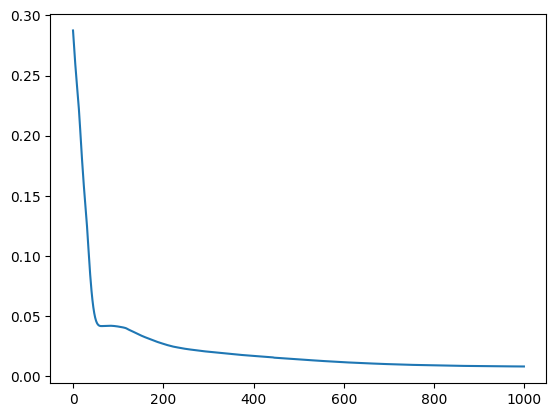

In [7]:
n_epochs = 1000  # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf  # init to infinity
best_weights = None
history = []

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train_std[start : start + batch_size]
            y_batch = Y_train_std[start : start + batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test_std)
    mse = loss_fn(y_pred, Y_test_std)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [8]:
Y_train_pred = model(X_train_std)
Y_test_pred = model(X_test_std)

In [9]:
Y_train_std = Y_train_std.detach().numpy()
Y_test_std = Y_test_std.detach().numpy()
Y_train_pred = Y_train_pred.detach().numpy()
Y_test_pred = Y_test_pred.detach().numpy()

,MSE Train,MSE Test,R2 Train,R2 Test
0,0.011758,0.012587,0.737625,0.765135
1,0.000824,0.001564,0.978557,0.949422
2,0.009935,0.010479,0.831021,0.800066


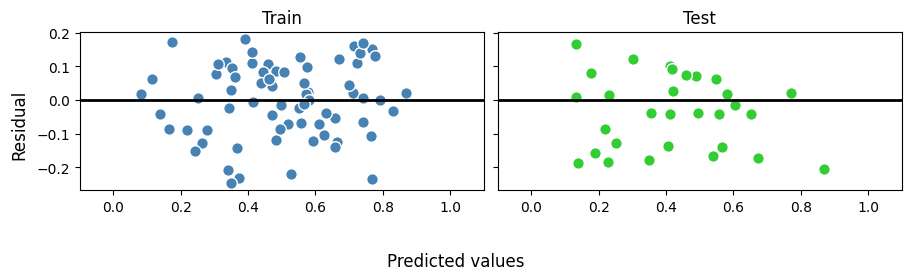

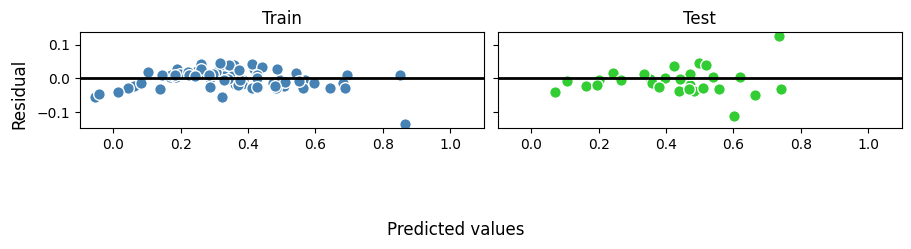

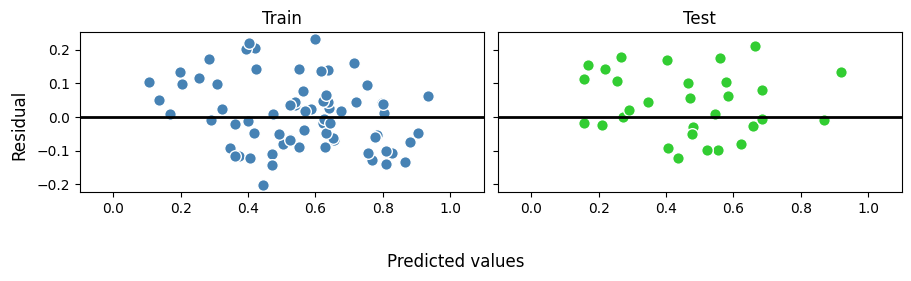

In [10]:
resArr = []
for i in range(Y.shape[1]):
    y_train = Y_train_std[:, i]
    y_test = Y_test_std[:, i]
    y_train_pred = Y_train_pred[:, i]
    y_test_pred = Y_test_pred[:, i]
    plot_res(y_train, y_test, y_train_pred, y_test_pred, xlim=[-0.1, 1.1])
    res = store_results(y_train, y_test, y_train_pred, y_test_pred)
    resArr.append(res)

dfRes = pd.DataFrame.from_dict(resArr)
dfRes